Install the required packages:

In [1]:
!pip install --upgrade pip
!pip install node2vec
!pip install pandas
!pip install scikit-learn
!pip install networkx
!pip install python-louvain
!pip install pydot
!pip install python-igraph
!pip install torch_geometric
!pip install torch
!pip install faiss-gpu

^C
Traceback (most recent call last):
  File "/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/bin/pip", line 8, in <module>
    sys.exit(main())
  File "/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 119, in _main
    level_number = setup_logging(
  File "/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 275, in setup_logging
    logging.config.dictConfig(
  File "/usr/lib/python3.10/logging/config.py", line 811, in dictConfig
    dictConf

In [2]:
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms.community import partition_quality
import pandas as pd
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from node2vec import Node2Vec
from sklearn.cluster import KMeans
import time

from random import uniform, seed
import time
from igraph import *

import pickle
import json

import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import normalized_mutual_info_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Community Detection

### Dataset Definition

For this lab, we used graph dataset of the [DBLP](http://dblp.uni-trier.de/) computer science bibliography. Nodes are authors of academic papers, and edges are constructed between a pair of authors if they published at least one paper together as co-authors. We put the dataset to **"dblp/"** folder in our submission directory. We downloaded it from [this page](https://snap.stanford.edu/data/com-DBLP.html). The authors (nodes) are put together based on the publication venue, journal or conference, of the academic papers, and they can be considered as ground-truth communities.

**Key Statistics**

- **Nodes**: 317,080 authors, representing the nodes
- **Edges**: 1,049,866 connections, indicating co-authorship relationships.

In [4]:
# Loading the graph data
edges_df = pd.read_csv('dblp/edges.txt', delimiter='\t', skiprows=4, names=['id_1', 'id_2'])

To identify communities in the graph, we applied the following community detection algorithms:
- **Louvain Algorithm**
- **Graph Convolutional Network**

and evaluated the resulting communities with the following measures:

**Internal Density**: Measures how dense the nodes within the communities are. The formula for obtaining this measures is: 
$$
\text{Internal Density}(\text{comm}_i) = \frac{2E_{c_i}}{n_{c_i}(n_{c_i} - 1)}
$$

  - **$E_{c_i}$**: Represents the number of edges within community $i$. It counts all the connections that exist between nodes in the same community.
  - **$n_{c_i}$**: Stands for the number of nodes within community $i$. It indicates how many nodes belong to the community.
  - **${n_{c_i}(n_{c_i} - 1)}$**: This is used in the denominator to account for the maximum possible number of connections between nodes within a community, excluding self-loops.


**External Density**: Measures how dense the nodes that belong to different communities are
$$
\text{External Density}(\text{comm}_i) = \frac{E_{ext_{c_i}}}{n_{c_i}(N - n_{c_i})}
$$

  - **$E_{ext_{c_i}}$**: The number of edges that connect nodes in community $i$ to nodes outside of that community. It measures the community's connectivity to the rest of the graph.
  - **$n_{c_i}$**: Represents the number of nodes within community $i$, as in the internal density formula.
  - **$N$**: The total number of nodes in the graph. This includes all nodes, both within and outside of community $i$.
  - **$N - n_{c_i}$**: Calculates the number of nodes that are not part of community $i$, providing a basis for understanding the potential for external connections.

**Coverage**: ratio of the number edges within communities and the total number of edges
$$
\text{Coverage} = \frac{\text{Number of intra-community edges}}{\text{Total number of edges in the graph}}
$$

- **Intra-community edges**: Edges that connect nodes within the same community.
- **Total number of edges in the graph**: The sum of all edges in the network, including both intra- and inter-community edges.


**Performance**: the number of edges within a community plus the number of inter-community non-edges (the absence of edges with other nodes of other communities), divided by the maximum possible number of edges of the network. 
$$
\text{Performance} = \frac{\text{Intra-community edges} + \text{Inter-community non-edges}}{\text{Total potential edges}}
$$

- **Intra-community edges**: As defined above.
- **Inter-community non-edges**: The potential connections between communities that do not exist. It is calculated as the difference between the total number of possible inter-community edges and the actual number of inter-community edges.
- **Total potential edges**: The maximum number of edges that the graph can have. For undirected graphs, this is $\frac{n(n - 1)}{2}$, and for directed graphs, it is $n(n - 1)$, where $n$ is the total number of nodes in the graph.

**Modularity**: Measures the degree distribution of the communities compared to a degree distribution of a randomly generated graph (null graph). The larger it is the better the community structure. It ranges from -0.5 to 1.
$$
Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \gamma \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)
$$
 - **$m$**: Represents the number of edges
 - **$A_{ij}$**: Element of the adjacency matrix of the graph, which is 1 if there is an edge between nodes $i$ and $j$, and 0 otherwise.
 - **$k_i$**: Degree of node $i$, i.e., the number of edges connected to node $i$.
 - **$\gamma$**: Resolution parameter that can scale the contribution of the null model, allowing for the detection of communities at different scales.
 - **$\delta(c_i, c_j)$**: Equals to 1 if $i$ and $j$ are in the same community, otherwise 0

We also compared the Communities to the Ground-Truth Communities, using the following measures:

**Normalized Mutual Information** - from information theory, evaluates the mutual dependence between 2 partitions (or in this ground truth from the predicted communities). 0 is no mutual information and 1 is perfect correlation. It is suitable for paritions of different sizes.
$$
MI(U, V) = \sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \left( \frac{|U_i \cap V_j|}{N} \right) \log \left( \frac{N |U_i \cap V_j|}{|U_i| |V_j|} \right)
$$
 - **$U$ and $V$**: The two partitions of a dataset, where $|U|$ and $|V|$ denote the number of communities within each partition
 - **$U_i$**: The set of nodes in $i$-th cluster of partition $U$
 - **$|U_i \cap V_j|$**: The number of nodes in common between community $i$ of $U$ and community $j$ of $V_j$
 - **$N$**: the total number of nodes


**Adjusted Rand Index** - measures similarity between 2 data communities. Min value is -1 and max is 1, where 1 means communities are identical, and -1 means complete disagreement. It is a version of Rand Index that is adjusted for chance.

$$
RI = \frac{\text{number of agreeing pairs}}{\text{number of pairs}}
$$

$$
ARI = \frac{RI - \text{Expected\_RI}}{\text{max(RI)} - \text{Expected\_RI}}
$$

- **Number of agreeing pairs**: The sum of the number of pairs of elements that are either in the same cluster in both partitions or in different clusters in both partitions.
- **Number of pairs**: The total number of possible pairs of elements in the dataset.
- **RI**: Rand Index as defined above.
- **Expected_RI**: The expected Rand Index under a model of randomness.
- **max(RI)**: The maximum possible value of the Rand Index, which occurs when the partitions are identical.

Community Detection measures: propagation, number of nodes propagated, play with seeds

### Loading Ground-Truth Communities

There are 13477 ground-truth communities, corresponding to the publication venue. They are of course not the only communities that can be created. Bigger communities can be formed based on the topic of the paper or the affiliation of the professors, for example.

In [5]:
ground_truth_communities = []
with open('dblp/communities.txt', 'r') as file:
    for line in file:
        community = set(line.strip().split('\t'))
        community = [int(node) for node in community]
        ground_truth_communities.append(community)

In [6]:
nodes_1 = list(edges_df['id_1'].values)
nodes_2 = list(edges_df['id_2'].values)
print("Number of unique nodes: ", len(set(nodes_1+nodes_2)))

nodes = []
for line in ground_truth_communities:
    for node in line:
        nodes.append(node)
print("Number of nodes in communities", len(nodes))
print("Number of unique nodes in communities: ", len(set(nodes)))

nodes = [int(node) for node in nodes]
print("Min index of a node: ", min(nodes))
print("Max index of a node: ", max(nodes))

Number of unique nodes:  317080
Number of nodes in communities 719820
Number of unique nodes in communities:  260998
Min index of a node:  0
Max index of a node:  425956


We can see that, in the Ground-Truth communities, not all nodes are assigned a community. 
Also, of those assigned to a community, they are assigned to around 2.75 communities on average. 
Thus, our ground-truth is not perfect and this will greatly affect the comparison with our results, that will only have exactly a single assignment of each node to a community.

Furthermore, the indexing of the nodes misses indexes in between as the last node's index does not match the number of nodes in the graph. So we need to do some preprocessing.

### Preprocessing the Nodes

In [7]:
# Step 1: Create a mapping from old indices to new
unique_nodes = set(edges_df['id_1']).union(set(edges_df['id_2']))

node_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_nodes)}

# Step 2: Update edges data
edges_df['id_1'] = edges_df['id_1'].map(node_mapping)
edges_df['id_2'] = edges_df['id_2'].map(node_mapping)

# Step 3: Update communities data
updated_communities = []
for community in ground_truth_communities:
    updated_community = {node_mapping[node] for node in community if node in node_mapping}
    updated_communities.append(updated_community)

ground_truth_communities = list(updated_communities)

G = nx.from_pandas_edgelist(edges_df, 'id_1', 'id_2')

### Applying Louvain Algorithm

In [26]:
# Load partition dictionary using pickle
with open('louvain_partition_dict.pkl', 'rb') as f:
    partition = pickle.load(f)

for node, comm_id in partition.items():
    G.nodes[node]['community'] = comm_id

##### The code below runs for 3 minutes. Alternatively, you can load its saved results using the cell above

In [9]:
### This takes 3 minutes
partition = community_louvain.best_partition(G, random_state=123)
# Add community to nodes attributes
for node, comm_id in partition.items():
    G.nodes[node]['community'] = comm_id

with open('louvain_partition_dict.pkl', 'wb') as f:
    pickle.dump(partition, f)

graph_data = nx.node_link_data(G)
with open('graph_with_louvain_communities.json', 'w') as f:
    json.dump(graph_data, f)

Now let's see the quality of the resulting communities using our measures.

#### Modularity

In [27]:
modularity = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity}")

Modularity: 0.8206532619018135


This is a high value for modularity, considering the maximum value is 1. Thus the nodes within communities are very connected. The graph has itself many edges, more than 3 times as many as there are edges, so this also must have contributed to such a high number.

#### Density

In [28]:
def calculate_densities(G, partition):
    internal_densities = {}
    external_densities = {}
    N = G.number_of_nodes()

    # Reverse the partition dictionary to group by community
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)

    for comm_id, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        E_c = subgraph.number_of_edges()
        n_c = len(nodes)
        internal_density = (2 * E_c) / (n_c * (n_c - 1)) if n_c > 1 else 0
        
        # For external edges, count edges from nodes in the community to nodes outside
        external_edges = sum(1 for node in nodes for neighbor in G.neighbors(node) if neighbor not in nodes)
        external_density = external_edges / (n_c * (N - n_c)) if N > n_c > 0 else 0

        internal_densities[comm_id] = internal_density
        external_densities[comm_id] = external_density

    return internal_densities, external_densities

internal_densities, external_densities = calculate_densities(G, partition)

In [29]:
external_densities_list = list(external_densities.values())
internal_densities_list = list(internal_densities.values())

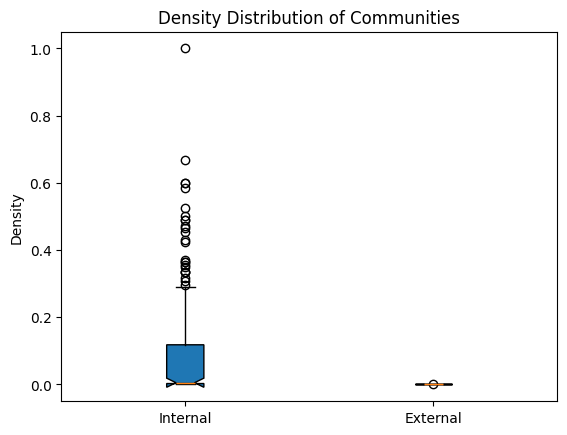

In [30]:
plt.boxplot([internal_densities_list, external_densities_list], patch_artist=True, notch=True, labels=['Internal', 'External'])
# Adding titles and labels
plt.title('Density Distribution of Communities')
plt.ylabel('Density')

# Show the plot
plt.show()

As we can see from the box plot above, Internal Densities are much higher than external densities. In fact, they are over 43000 times larger than the external ones on average.

In [14]:
print("Internal Density: ", np.mean(internal_densities_list))
print("External Density: ", np.mean(external_densities_list))
print(f"Internal is {np.mean(internal_densities_list)/np.mean(external_densities_list)} times bigger")

Internal Density:  0.09341826938586299
External Density:  2.1658981216545864e-06
Internal is 43131.42361215879 times bigger


#### Coverage and Performance

In [15]:
communities = []
unique_communities = set(partition.values())
for comm_id in unique_communities:
    communities.append({node for node, c_id in partition.items() if c_id == comm_id})

# Calculate coverage
coverage, performance = partition_quality(G, communities)

In [16]:
print("Coverage: ", round(coverage,3))
print("Performance: ", round(performance,3))

Coverage:  0.843
Performance:  0.98


Coverage shows that 84.3% of all edges are within communities. It is a pretty good result. We will try another algorithm to compare it with this value.

Such a high value of performance indicates that the communities have very sparse connections between communities, and very dense connections within communities. It effectively identified the "natural" divisions within  the network.

#### Comparison with the Ground-Truth

In [17]:
def communities_to_labels(communities, node_list):
    labels = [-1] * len(node_list)
    node_index = {node: idx for idx, node in enumerate(node_list)}
    for comm_idx, community in enumerate(communities):
        for node in community:
            labels[node_index[node]] = comm_idx
    return labels

# Get a list of all nodes
all_nodes = list(set.union(*ground_truth_communities).union(*communities))

# Convert both sets of communities to label format
gt_labels = communities_to_labels(ground_truth_communities, all_nodes)
louvain_labels = communities_to_labels(communities, all_nodes)

# Compute NMI and ARI
nmi = normalized_mutual_info_score(gt_labels, louvain_labels)
ari = adjusted_rand_score(gt_labels, louvain_labels)

print(f"NMI: {nmi}, ARI: {ari}")

NMI: 0.3162318798881319, ARI: 0.006948805684335143


Both NMI and ARI are very low. Such a low value must have been a result of the following factors:
- The great difference in the sizes of the ground-truth and Louvain communities. There are 75 times more ground-truth communities.
- Ground-truth communities do not contain all nodes
- Nodes contained in ground-truth communities appear in 2.75 communities

### Graph Convolutional Network

It is a powerful community detection model. It learns low-dimensional embeddings for each node, which are then clustered to find the communities. 

To run the model, you can run the code in the second to the next cell. It runs for around 3 minutes with GPU access. Alternatively, you can load the results as follows:

In [35]:
predicted_labels = np.load('predicted_labels_GCN.npy')
node_embeddings = np.load("node_embedding.npy")

edges_df = pd.read_csv('dblp/edges.txt', delimiter='\t', skiprows=4, names=['id_1', 'id_2'])
unique_nodes = set(edges_df['id_1']).union(set(edges_df['id_2']))
node_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_nodes)}

# Step 2: Update edges data
edges_df['id_1'] = edges_df['id_1'].map(node_mapping)
edges_df['id_2'] = edges_df['id_2'].map(node_mapping)

ground_truth_communities = []
with open('dblp/communities.txt', 'r') as file:
    for line in file:
        community = set(line.strip().split('\t'))
        community = [int(node) for node in community]
        ground_truth_communities.append(community)

# Step 3: Update communities data
updated_communities = []
for community in ground_truth_communities:
    updated_community = {node_mapping[node] for node in community if node in node_mapping}
    updated_communities.append(updated_community)

ground_truth_communities = list(updated_communities)

G = nx.from_pandas_edgelist(edges_df, 'id_1', 'id_2')

##### The cell below runs for 10 minutes, please load the results with the above cell to save time

In [ ]:
data = from_networkx(G).to(device)
num_nodes = data.num_nodes

# Use degrees as node features
degrees = np.array([val for (node, val) in G.degree()])
degrees = (degrees - degrees.mean()) / degrees.std()
data.x = torch.tensor(degrees, dtype=torch.float).unsqueeze(1).to(device)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GCN model
num_features = data.num_features
hidden_channels = 16
# Initialize the GCN model and move it to GPU
model = GCN(num_features=data.num_features, hidden_channels=16).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # Use a placeholder for loss since we don't have labels
    loss = out.sum()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}: Loss {loss.item()}')

node_embeddings = out.detach().cpu().numpy()

# Now we apply KMeans to cluster the nodes to get the communities
n_clusters = len(ground_truth_communities)  # 13477 communities
kmeans = faiss.Kmeans(d=node_embeddings.shape[1], k=n_clusters, niter=20, verbose=True, gpu=True)
kmeans.train(node_embeddings)

predicted_labels = kmeans.index.search(node_embeddings, 1)[1].reshape(-1)

np.save("predicted_labels_GCN.npy",predicted_labels)

#### Comparison with the Ground-Truth

In [32]:
node_to_community = {}
for i, community in enumerate(ground_truth_communities):
    for node in community:
        node_to_community[int(node)] = i

max_node_id = max(node_to_community.keys())  # Find the highest node ID in your mapping
ground_truth_labels = [node_to_community.get(node, -1) for node in range(max_node_id + 1)]

In [33]:
# Calculate NMI between ground truth and predicted communities
nmi_score = normalized_mutual_info_score(ground_truth_labels, predicted_labels)
print(f'NMI Score: {nmi_score}')
ari_score = adjusted_rand_score(ground_truth_labels,predicted_labels)
print(f"Adjusted Rand Score: {ari_score}")

NMI Score: 0.350432123936192
Adjusted Rand Score: 3.430259923277492e-05


NMI score is slightly higher than Louvain, but ARI is slightly lower than Louvain.

#### Modularity

In [36]:
partition_gcn = {node_index: community_index for node_index, community_index in enumerate(predicted_labels)}
modularity = community_louvain.modularity(partition_gcn, G)
print(f"Modularity: {modularity}")

Modularity: 0.014873851772620217


This is a surprisingly low value, much lower than 82% of Louvain, despite better value for NMI. The algorithm seems to be fitted too much to the ground truth labels.

#### Density

In [37]:
internal_densities, external_densities = calculate_densities(G, partition_gcn)

In [38]:
external_densities_list = list(external_densities.values())
internal_densities_list = list(internal_densities.values())

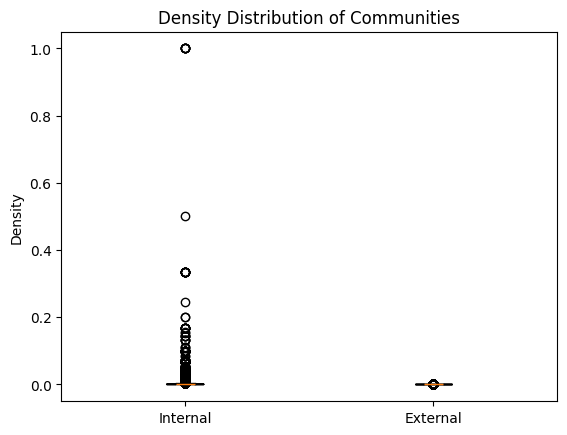

In [39]:
plt.boxplot([internal_densities_list, external_densities_list], patch_artist=True, notch=True, labels=['Internal', 'External'])
# Adding titles and labels
plt.title('Density Distribution of Communities')
plt.ylabel('Density')

# Show the plot
plt.show()

Although Internal Densities are higher than external densities, i.e. 171 times higher, the difference is not as big as for Louvain. But the model clearly form some fair communities.

In [40]:
print("Internal Density: ", np.mean(internal_densities_list))
print("External Density: ", np.mean(external_densities_list))
print(f"Internal is {np.mean(internal_densities_list)/np.mean(external_densities_list)} times bigger")

Internal Density:  0.003956196119073558
External Density:  2.303801003458191e-05
Internal is 171.72473287124143 times bigger


#### Coverage and Performance

In [41]:
communities = []
unique_communities = set(partition_gcn.values())
for comm_id in unique_communities:
    communities.append({node for node, c_id in partition_gcn.items() if c_id == comm_id})

# Calculate coverage
coverage, performance = partition_quality(G, communities)

In [42]:
print("Coverage: ", round(coverage,3))
print("Performance: ", round(performance,3))

Coverage:  0.015
Performance:  1.0


Performance is the highest possible, thus the algorithm effectively identified all "natural" divisions within the network. It is slighly larger than Louvain. However, coverage is much smaller.

Coverage shows that 84.3% of all edges are within communities. It is a pretty good result. We will try another algorithm to compare it with this value.

Such a high value of performance indicates that the communities have very sparse connections between communities, and very dense connections within communities. It effectively identified the "natural" divisions within  the network.

## Influence Maximization

### Problem Definition

By applying influence maximization on the Twitch social network dataset, we can find the set of streamers that maximize the flow of information. A similar analysis can be done by a gaming company which would like to promote their new game and wants to minimize its expenses on promotion.

### Dataset Definition

For this lab, we used graph dataset of Twitch Social Networks. Nodes are the users who stream the gaming content in the platform, and edges are mutual friendships between them. We put the dataset to "twitch" folder in our submission directory. We downloaded it from [this page](https://snap.stanford.edu/data/twitch-social-networks.html). Each node also a set of anonymized features, based on the games played and liked, location and streaming habits. We would like to assign the edge weights based on amount of commonalities between these features. For our analysis, we used the French-speaking twitch streamers.

**Key Statistics**

- **Nodes**: 6,549 streamers
- **Edges**: 112,666 mutual friendships between them

In [43]:
from gensim.models import Word2Vec
from node2vec import Node2Vec
import networkx as nx

In [44]:
data_path = 'twitch/musae_FR_edges.csv'

### Using Machine Learning for Influence Maximization

We are first obtaining Graph Embeddings using Node2Vec, to leverage the structural information encoded in these embeddings to identify nodes that, if activated, could maximize the spread of information across the network.


In [64]:
embeddings = np.load('IM_Embedding_vectors.npy')

##### The code below takes 5 minutes to execute. Alternatively load the results with the code above.

In [46]:
# Step 1: Load the Graph Data
edges_df = pd.read_csv(data_path, delimiter=',', skiprows=4, names=['id_1', 'id_2'])

# Assuming 'G' is the directed graph created from the edge list
G = nx.from_pandas_edgelist(edges_df, source='id_1', target='id_2', create_using=nx.DiGraph())

# Initialize Node2Vec model
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=4)

# Train Node2Vec model
model = node2vec.fit(window=5, min_count=1, batch_words=4,sg=1)

# Generate embeddings for each node
embeddings = model.wv

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  5.91it/s]


In [65]:
# Assume 'embeddings' is a dictionary with node IDs as keys and embedding vectors as values
embedding_vectors = np.array([embeddings[node_id] for node_id in range(len(G))])
print(embedding_vectors)

[[-0.2676502   0.14241387  0.9070814  ... -0.7464064   0.0769706
   0.61002034]
 [-0.25061625 -0.41902637  0.0079925  ... -0.20735204  0.093123
  -0.19047548]
 [ 0.173244   -0.0598061   1.0059117  ... -0.64039457  0.291323
   1.2455987 ]
 ...
 [-0.28430277 -0.00393142  0.05948021 ... -0.57154703 -0.15448073
   0.10493864]
 [-0.05748443  0.14995278  0.24142067 ... -0.6190479   0.5025469
   0.31988227]
 [ 0.05162992 -0.9301659   0.24904874 ... -0.6857389   0.414756
  -0.05364721]]


In [48]:
# Cluster nodes based on their embeddings
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embedding_vectors)

# Identify central nodes within each cluster
# This is a simplified example where we choose the closest node to each cluster center
cluster_centers = kmeans.cluster_centers_
central_nodes_per_cluster = []
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i)[0]
    cluster_embeddings = embedding_vectors[cluster_indices]
    center_embedding = cluster_centers[i]
    distances = np.linalg.norm(cluster_embeddings - center_embedding, axis=1)
    central_node_index = cluster_indices[np.argmin(distances)]
    central_nodes_per_cluster.append(central_node_index)

/home/sayyor/.local/share/virtualenvs/Decision_Modelling-5MWfXJOk/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
#Most Influenced Node for IM
central_nodes_per_cluster

[4981, 5617, 3735, 6212, 3432, 2655, 4393, 579, 3779, 4292]

In [50]:
def simulate_icm(network, seed_nodes, activation_prob=0.1):
    """
    Simulate the Independent Cascade Model of information spread.
    :param network: NetworkX graph object.
    :param seed_nodes: List of nodes to start the spread.
    :param activation_prob: Probability of activating a neighboring node.
    :return: Set of activated nodes by the end of the simulation.
    """
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        next_round_activated = set()
        for node in newly_activated:
            for neighbor in network.neighbors(node):
                if neighbor not in activated and np.random.rand() < activation_prob:
                    next_round_activated.add(neighbor)
                    activated.add(neighbor)
        newly_activated = next_round_activated
    return activated

# Usage
seed_nodes = [node_id for node_id in central_nodes_per_cluster]  # Central nodes from clustering
influence_set = simulate_icm(G, seed_nodes)
print(f"Total nodes influenced: {len(influence_set)}")

Total nodes influenced: 98


In [63]:
print(round((len(influence_set) / G.number_of_nodes()) * 100,3), "% of nodes were influenced with the selected nodes")
print(round((len(central_nodes_per_cluster) / G.number_of_nodes()) * 100,3), "% of nodes that influenced the nodes")

1.496 % of nodes were influenced with the selected nodes
0.153 % of nodes that influenced the nodes


We can see above how many nodes were reached using the central nodes found, when appllying the Independent Cascade Model. 
Thus, 0.15% of nodes influenced 1.5% of other nodes in the network, which is impressive.